In [2]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer

In [3]:
train=pd.read_csv('/kaggle/input/fsajhd/df_train_clean.csv')
test=pd.read_csv('/kaggle/input/fsajhd/df_test_clean.csv')
sub=pd.read_csv('/kaggle/input/fsajhd/sample_submission.csv')

In [4]:
tarain=pd.read_csv('/kaggle/input/fsajhd/train.csv')

In [5]:
tarain.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [6]:
train.head(5)

,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Displacement,Cylinder Count,model_age
0,31,213000,2,0,312,71,2,1,4200,172.0,1.6,4.0,18
1,28,143250,2,0,263,10,0,1,4999,252.0,3.9,8.0,23
2,9,136731,1,0,38,71,2,1,13900,320.0,5.3,8.0,23
3,16,19500,2,2,29,14,2,1,45000,420.0,5.0,8.0,8
4,36,7388,2,0,29,10,2,1,97500,208.0,2.0,4.0,4


In [7]:
test.sample(5)

,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,Horsepower,Displacement,Cylinder Count,model_age
34387,11,13750,2,2,304,14,2,1,485.000000,6.400000,8.000000,4
92002,43,21613,2,0,304,155,2,0,244.553252,2.000000,6.374268,3
121389,9,25250,2,2,312,118,2,1,490.000000,6.200000,8.000000,4
102511,52,43000,5,0,304,14,2,1,425.000000,4.526078,6.374268,5
95804,36,54500,2,0,29,14,2,1,362.000000,3.000000,6.000000,7


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   brand           188533 non-null  int64  
 1   milage          188533 non-null  int64  
 2   fuel_type       188533 non-null  int64  
 3   transmission    188533 non-null  int64  
 4   ext_col         188533 non-null  int64  
 5   int_col         188533 non-null  int64  
 6   accident        188533 non-null  int64  
 7   clean_title     188533 non-null  int64  
 8   price           188533 non-null  int64  
 9   Horsepower      188533 non-null  float64
 10  Displacement    188533 non-null  float64
 11  Cylinder Count  188533 non-null  float64
 12  model_age       188533 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 18.7 MB


## XgBoost

In [11]:
import joblib
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Load dataset
X = train.drop(columns=['price'])
y = train['price']

# Display dataset shape
print(f"Dataset Shape: X={X.shape}, y={y.shape}")

# Define numerical and categorical columns
num_cols = ['milage', 'Horsepower', 'Displacement', 'Cylinder Count', 'model_age']
cat_cols = ['brand', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

# Updated hyperparameters from Optuna with GPU support
tuned_params = {
    'n_estimators': 200,
    'learning_rate': 0.026075961680376267,
    'max_depth': 7,
    'min_child_weight': 8,
    'subsample': 0.6403035387419401,
    'colsample_bytree': 0.5532517223827789,
    'gamma': 0.143179155034863,
    'reg_alpha': 2.1450990765269337e-07,
    'reg_lambda': 0.05942705889240155,
    'tree_method': 'gpu_hist',  # Enable GPU support
    'random_state': 42
}

# Define preprocessing pipeline
num_pipeline = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, num_cols)
    ],
    remainder='passthrough'
)

# Number of folds for cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
oof_df = pd.DataFrame(columns=['ID', 'Actual', 'OOF_Pred_XGBoost', 'Fold'])

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), start=1):
    print(f"\nTraining Fold {fold}/{n_folds}...")
    
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Display train and validation set shapes
    print(f"Fold {fold} Train Shape: {X_tr.shape}, Validation Shape: {X_val.shape}")
    
    # Create pipeline with preprocessor and XGBoost model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(**tuned_params))
    ])
    
    # Train model
    pipeline.fit(X_tr, y_tr)
    
    # Predict on validation set
    y_val_pred = pipeline.predict(X_val)
    oof_preds[val_idx] = y_val_pred
    
    # Compute fold RMSE
    fold_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    print(f"Fold {fold} RMSE: {fold_rmse:.4f}")
    
    # Store fold results in DataFrame
    fold_df = pd.DataFrame({
        'ID': X.index[val_idx],
        'Actual': y_val.values,
        'OOF_Pred_XGBoost': y_val_pred,
        'Fold': fold
    })
    
    oof_df = pd.concat([oof_df, fold_df], ignore_index=True)

# Compute overall RMSE
oof_rmse = mean_squared_error(y, oof_preds, squared=False)
print(f"\nOverall OOF RMSE: {oof_rmse:.4f}")

# Save OOF predictions
oof_df.to_csv('oof_predictions_xgboost.csv', index=False)
print("OOF predictions saved to 'oof_predictions_xgboost.csv'.")

# Save trained model
joblib.dump(pipeline, 'xgboost_model.pkl')
print("Model saved as 'xgboost_model.pkl'.")


Dataset Shape: X=(188533, 12), y=(188533,)

Training Fold 1/5...
Fold 1 Train Shape: (150826, 12), Validation Shape: (37707, 12)


[08:39:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[08:39:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[08:39:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future ver

Fold 1 RMSE: 67968.8574

Training Fold 2/5...
Fold 2 Train Shape: (150826, 12), Validation Shape: (37707, 12)


[08:39:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[08:39:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[08:39:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



Fold 2 RMSE: 68610.0619

Training Fold 3/5...
Fold 3 Train Shape: (150826, 12), Validation Shape: (37707, 12)


[08:39:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[08:39:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



Fold 3 RMSE: 74037.1875

Training Fold 4/5...
Fold 4 Train Shape: (150827, 12), Validation Shape: (37706, 12)


[08:39:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[08:39:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



Fold 4 RMSE: 76528.0761

Training Fold 5/5...
Fold 5 Train Shape: (150827, 12), Validation Shape: (37706, 12)


[08:39:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



Fold 5 RMSE: 76533.5417

Overall OOF RMSE: 72832.0142
OOF predictions saved to 'oof_predictions_xgboost.csv'.
Model saved as 'xgboost_model.pkl'.



Computing SHAP values...


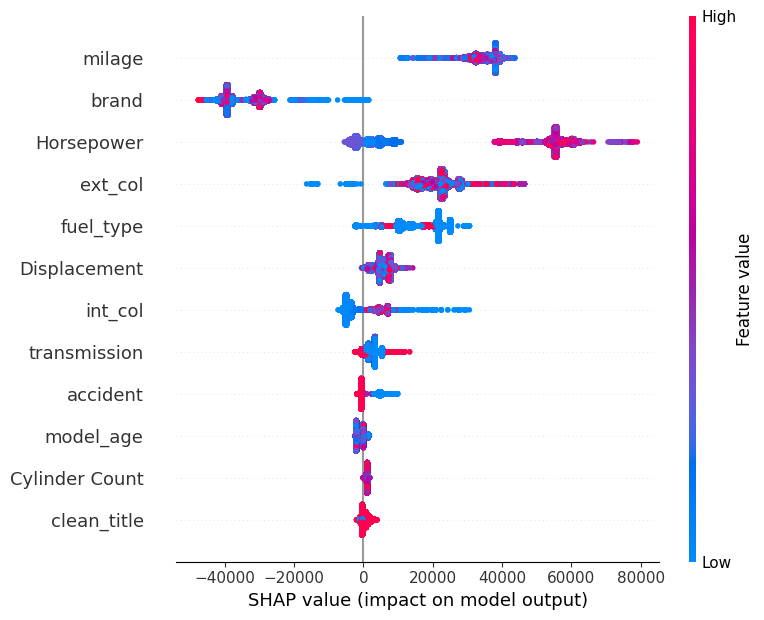

SHAP summary plot saved as 'shap_summary_plot.png'.


<Figure size 640x480 with 0 Axes>

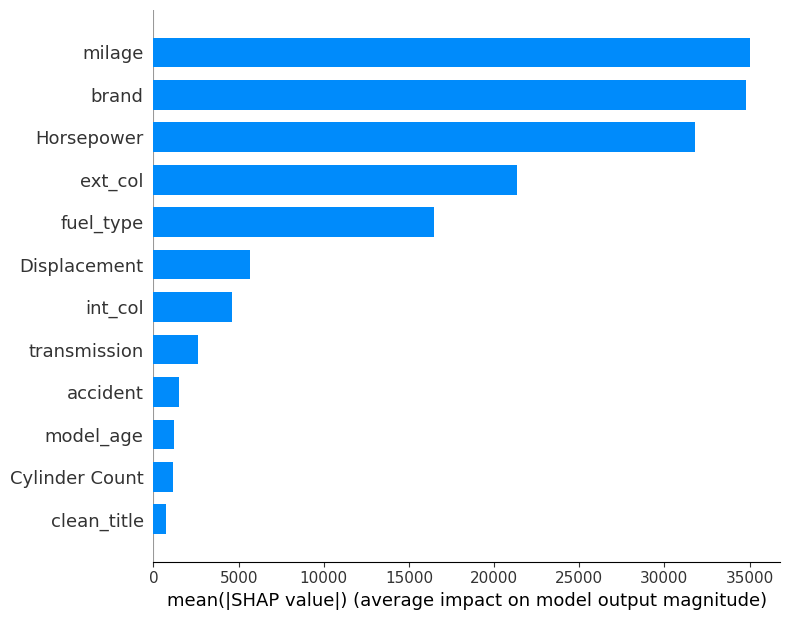

SHAP feature importance plot saved as 'shap_feature_importance.png'.


<Figure size 640x480 with 0 Axes>

In [12]:

# ---------------- SHAP Interpretation ----------------

print("\nComputing SHAP values...")

# Extract the trained model
trained_model = pipeline.named_steps['model']

# Use SHAP to interpret model
explainer = shap.Explainer(trained_model)
shap_values = explainer(X)

# SHAP summary plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X)
plt.savefig("shap_summary_plot.png")
print("SHAP summary plot saved as 'shap_summary_plot.png'.")

# SHAP feature importance plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X, plot_type="bar")
plt.savefig("shap_feature_importance.png")
print("SHAP feature importance plot saved as 'shap_feature_importance.png'.")


In [13]:
final_test_predictions = pipeline.predict(test)

# Save submission file
sub = pd.read_csv('/kaggle/input/fsajhd/sample_submission.csv')
sub['price'] = final_test_predictions
sub.to_csv('XgBoost_submission.csv', index=False)
print("Submission file saved as 'lrsubmission.csv'.")
sub.head()


Submission file saved as 'lrsubmission.csv'.


,id,price
0,188533,17727.068359
1,188534,77704.109375
2,188535,51890.683594
3,188536,31403.695312
4,188537,31094.761719
